# Car Insurance Telematics - Claim Severity Model

**Notebook 3: XGBoost Regression with Optuna Optimization**

This notebook develops a machine learning model to predict claim severity (claim amount) using telematics features.

## Objectives:
- Build XGBoost regression model for claim severity prediction
- Optimize hyperparameters using Optuna with RMSE metric
- Evaluate model performance with 3-fold cross-validation
- Analyze feature importance for claim amounts
- Generate business insights for pricing strategies

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                           r2_score, mean_absolute_percentage_error)

# Hyperparameter optimization
import optuna
from optuna.integration import XGBoostPruningCallback

# Utilities
import joblib
from datetime import datetime
import os
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("XGBoost Claim Severity Model")
print("=" * 50)
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

XGBoost Claim Severity Model
Timestamp: 2025-07-12 22:24:08


## 1. Data Loading and Preparation

In [11]:
# Load processed features
data_path = '../data/processed/'

# Load driver-level features (main dataset for modeling)
df = pd.read_csv(os.path.join(data_path, 'driver_level_features.csv'))

print(f"Dataset shape: {df.shape}")
print(f"\nDataset info:")
df.info()

# Display first few rows
df.head()

Dataset shape: (1200, 55)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   driver_id                       1200 non-null   object 
 1   total_trips                     1200 non-null   int64  
 2   duration_minutes_mean           1200 non-null   float64
 3   duration_minutes_std            1200 non-null   float64
 4   total_driving_time_minutes      1200 non-null   float64
 5   distance_miles_mean             1200 non-null   float64
 6   distance_miles_std              1200 non-null   float64
 7   total_distance_miles            1200 non-null   float64
 8   average_speed_mph_mean          1200 non-null   float64
 9   average_speed_mph_std           1200 non-null   float64
 10  max_speed_mph_mean              1200 non-null   float64
 11  max_speed_mph_max               1200 non-null   float6

,driver_id,total_trips,duration_minutes_mean,duration_minutes_std,total_driving_time_minutes,distance_miles_mean,distance_miles_std,total_distance_miles,average_speed_mph_mean,average_speed_mph_std,...,avg_duration_per_trip,harsh_driving_intensity,speed_risk_score,distraction_risk_score,timing_risk_score,composite_risk_score,risk_category,high_mileage_driver,frequent_driver,consistent_driver
0,0002af179ff1223f,12,32.6250,22.2946,391.5,19.2492,12.2774,230.99,39.0583,6.1187,...,32.625000,3.2500,0.03908,0.0000,9.5830,34.428324,High,0,0,1
1,003485c0a33db1b4,17,24.0529,12.4703,408.9,10.1388,6.6773,172.36,29.6059,4.7059,...,24.052941,2.5295,0.03780,4.0386,9.7065,29.266940,High,0,0,1
2,00b03adcdee26a16,9,28.9889,21.1209,260.9,24.0533,22.5892,216.48,47.6333,4.9513,...,28.988889,11.2222,0.13904,0.8990,9.4435,114.601912,Very High,0,0,1
3,00c67cb4783ab2fa,18,23.7889,9.5601,428.2,18.0206,7.8179,324.37,49.1833,4.1490,...,23.788889,9.5000,0.11128,1.0238,9.7225,97.489784,Very High,0,0,1
4,00c89280fe405154,17,23.0824,12.5857,392.4,12.4771,6.7808,212.11,30.6824,4.3216,...,23.082353,1.0000,0.01004,1.7294,7.6475,12.397212,Medium,0,0,1


In [12]:
# Create synthetic claim severity data for demonstration
# In real scenario, you would have actual claim amount data
np.random.seed(42)

# First, create claim indicators (similar to classification model)
claim_prob = (
    0.05 +  # Base claim rate
    0.15 * (df['composite_risk_score'] / df['composite_risk_score'].max()) +
    0.10 * df['harsh_driving_intensity'] / df['harsh_driving_intensity'].max() +
    0.08 * df['speed_risk_score'] / df['speed_risk_score'].max() +
    0.05 * df['distraction_risk_score'] / df['distraction_risk_score'].max()
)
claim_prob = np.clip(claim_prob, 0, 0.4)
has_claim = np.random.binomial(1, claim_prob)

# Create claim severity for drivers with claims
# Base severity influenced by risk factors
base_severity = 2000  # Base claim amount

# Risk multipliers for claim severity
severity_multiplier = (
    1.0 +
    0.8 * (df['composite_risk_score'] / df['composite_risk_score'].max()) +
    0.6 * (df['speed_risk_score'] / df['speed_risk_score'].max()) +
    0.4 * (df['harsh_driving_intensity'] / df['harsh_driving_intensity'].max()) +
    0.3 * (df['total_distance_miles'] / df['total_distance_miles'].max()) +  # Higher mileage = higher severity
    0.2 * df['night_driving_mean'] +  # Night driving increases severity
    0.1 * df['excessive_speed_flag_mean']  # Excessive speed increases severity
)

# Generate claim amounts with log-normal distribution (realistic for insurance)
log_mean = np.log(base_severity * severity_multiplier)
log_std = 0.6  # Controls variability

claim_amounts = np.random.lognormal(log_mean, log_std)

# Only keep claim amounts for drivers who actually have claims
df['has_claim'] = has_claim
df['claim_amount'] = np.where(has_claim == 1, claim_amounts, 0)

# Filter to only drivers with claims for severity modeling
df_claims = df[df['has_claim'] == 1].copy()

print(f"Total drivers: {len(df)}")
print(f"Drivers with claims: {len(df_claims)}")
print(f"Claim rate: {df['has_claim'].mean():.3f}")
print(f"\nClaim amount statistics:")
print(df_claims['claim_amount'].describe())

# Note: Replace this section with actual claim data loading in production

Total drivers: 1200
Drivers with claims: 170
Claim rate: 0.142

Claim amount statistics:
count      170.000000
mean      3941.369041
std       2572.240938
min        600.051309
25%       2132.287829
50%       3172.570372
75%       5048.468184
max      16010.381304
Name: claim_amount, dtype: float64


## 2. Exploratory Data Analysis for Claim Severity

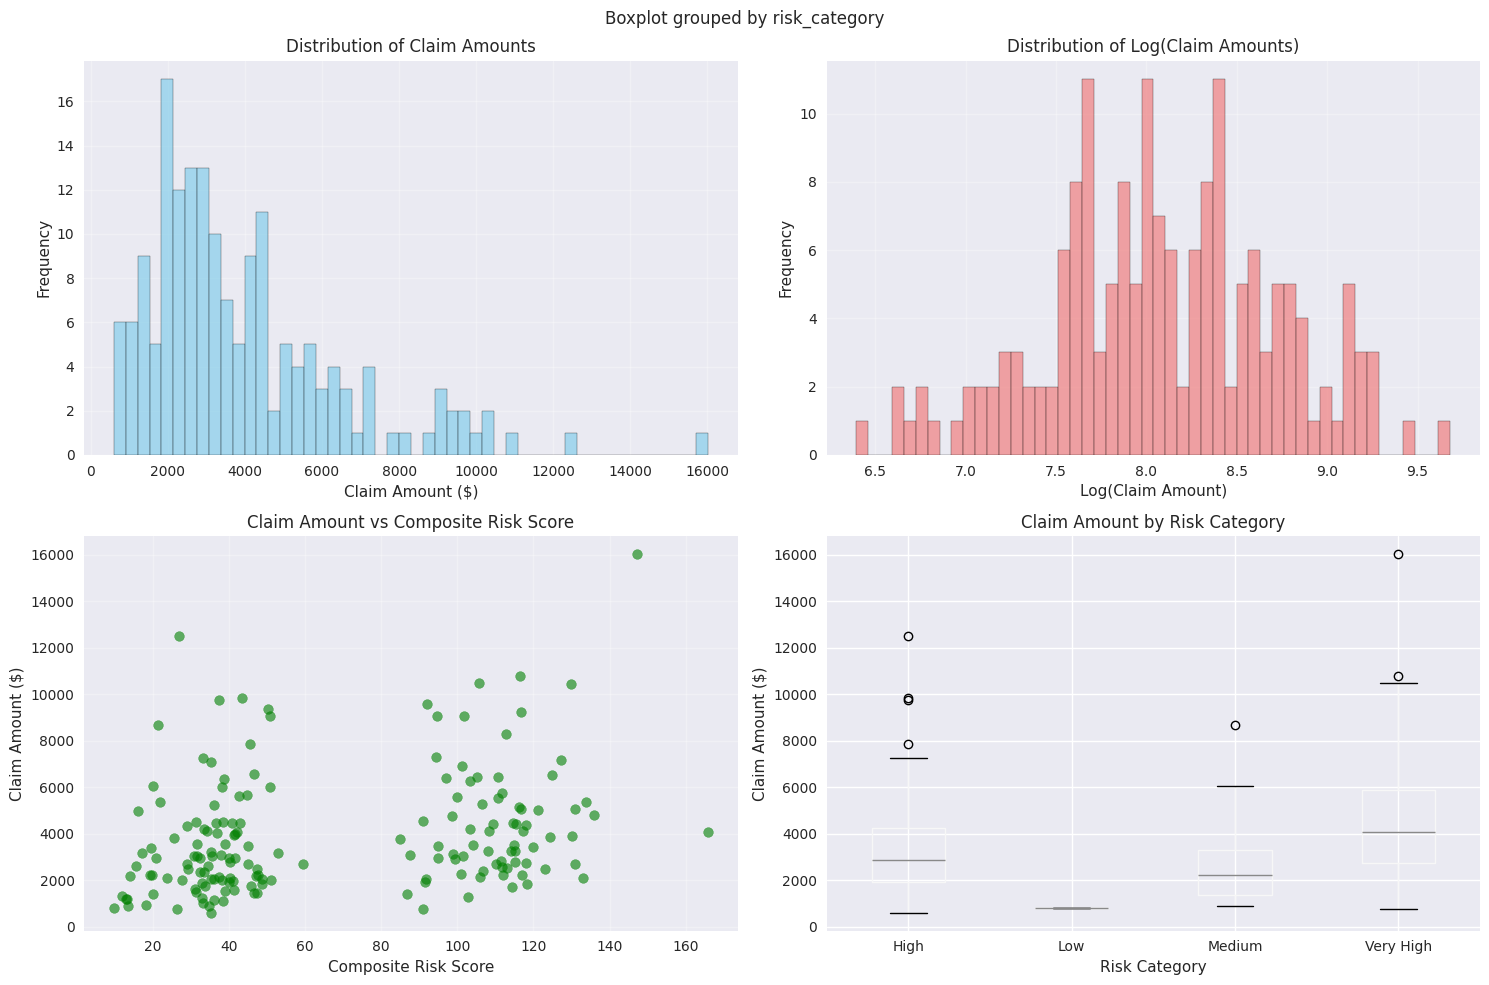


Claim Amount Statistics by Risk Category:
               count     mean   median      std     min       max
risk_category                                                    
High              72  3413.75  2865.12  2257.84  600.05  12515.60
Low                1   814.15   814.15      NaN  814.15    814.15
Medium            18  2933.67  2217.13  2096.07  873.42   8690.33
Very High         79  4691.42  4065.12  2747.95  761.66  16010.38


In [13]:
# Analyze claim amount distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Claim amount distribution
axes[0,0].hist(df_claims['claim_amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Claim Amounts')
axes[0,0].set_xlabel('Claim Amount ($)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# 2. Log-transformed claim amounts (more normal)
log_claims = np.log(df_claims['claim_amount'])
axes[0,1].hist(log_claims, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Distribution of Log(Claim Amounts)')
axes[0,1].set_xlabel('Log(Claim Amount)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

# 3. Claim amount vs composite risk score
axes[1,0].scatter(df_claims['composite_risk_score'], df_claims['claim_amount'], 
                 alpha=0.6, color='green')
axes[1,0].set_title('Claim Amount vs Composite Risk Score')
axes[1,0].set_xlabel('Composite Risk Score')
axes[1,0].set_ylabel('Claim Amount ($)')
axes[1,0].grid(True, alpha=0.3)

# 4. Box plot by risk category
if 'risk_category' in df_claims.columns:
    df_claims.boxplot(column='claim_amount', by='risk_category', ax=axes[1,1])
    axes[1,1].set_title('Claim Amount by Risk Category')
    axes[1,1].set_xlabel('Risk Category')
    axes[1,1].set_ylabel('Claim Amount ($)')
else:
    # Create risk categories based on composite risk score
    df_claims['risk_category'] = pd.cut(
        df_claims['composite_risk_score'],
        bins=[-np.inf, 10, 25, 50, np.inf],
        labels=['Low', 'Medium', 'High', 'Very High']
    )
    df_claims.boxplot(column='claim_amount', by='risk_category', ax=axes[1,1])
    axes[1,1].set_title('Claim Amount by Risk Category')
    axes[1,1].set_xlabel('Risk Category')
    axes[1,1].set_ylabel('Claim Amount ($)')

plt.tight_layout()
plt.savefig('claim_severity_eda.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical summary by risk category
print("\nClaim Amount Statistics by Risk Category:")
print("=" * 50)
severity_by_risk = df_claims.groupby('risk_category')['claim_amount'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)
print(severity_by_risk)

## 3. Feature Selection and Preprocessing

In [14]:
# Define features for modeling (exclude ID columns, target, and categorical variables)
exclude_cols = ['driver_id', 'has_claim', 'claim_amount', 'risk_category']
feature_cols = [col for col in df_claims.columns if col not in exclude_cols]

print(f"Total features available: {len(feature_cols)}")
print(f"\nSelected features:")
for i, feature in enumerate(feature_cols, 1):
    print(f"{i:2d}. {feature}")

Total features available: 53

Selected features:
 1. total_trips
 2. duration_minutes_mean
 3. duration_minutes_std
 4. total_driving_time_minutes
 5. distance_miles_mean
 6. distance_miles_std
 7. total_distance_miles
 8. average_speed_mph_mean
 9. average_speed_mph_std
10. max_speed_mph_mean
11. max_speed_mph_max
12. harsh_braking_events_mean
13. harsh_braking_events_sum
14. harsh_acceleration_events_mean
15. harsh_acceleration_events_sum
16. sharp_cornering_events_mean
17. sharp_cornering_events_sum
18. total_harsh_events_mean
19. total_harsh_events_sum
20. harsh_events_per_mile_mean
21. harsh_events_per_minute_mean
22. phone_usage_seconds_mean
23. phone_usage_seconds_sum
24. phone_usage_percent_mean
25. phone_usage_flag_mean
26. excessive_phone_use_mean
27. speeding_percent_mean
28. speed_variance_mean
29. speed_ratio_mean
30. high_speed_flag_mean
31. excessive_speed_flag_mean
32. night_driving_mean
33. rush_hour_mean
34. high_risk_time_mean
35. long_trip_flag_mean
36. short_trip_f

In [15]:
# Prepare features and target
X = df_claims[feature_cols].copy()
y = df_claims['claim_amount'].copy()

# Handle any missing values
print(f"Missing values per feature:")
missing_counts = X.isnull().sum()
if missing_counts.sum() > 0:
    print(missing_counts[missing_counts > 0])
    X = X.fillna(X.median())
else:
    print("No missing values found")

# Check for infinite values
inf_counts = np.isinf(X).sum()
if inf_counts.sum() > 0:
    print(f"\nInfinite values found:")
    print(inf_counts[inf_counts > 0])
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

# Option to use log-transformed target (often better for claim amounts)
use_log_target = True
if use_log_target:
    y_original = y.copy()
    y = np.log(y)
    print(f"\nUsing log-transformed target variable")
    print(f"Original target range: ${y_original.min():.2f} - ${y_original.max():.2f}")
    print(f"Log target range: {y.min():.3f} - {y.max():.3f}")
else:
    print(f"\nUsing original target variable")

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target statistics: Mean={y.mean():.3f}, Std={y.std():.3f}")

Missing values per feature:
No missing values found

Using log-transformed target variable
Original target range: $600.05 - $16010.38
Log target range: 6.397 - 9.681

Final feature matrix shape: (170, 53)
Target statistics: Mean=8.086, Std=0.633


## 4. Train-Test Split and Cross-Validation Setup

In [16]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain target stats: Mean={y_train.mean():.3f}, Std={y_train.std():.3f}")
print(f"Test target stats: Mean={y_test.mean():.3f}, Std={y_test.std():.3f}")

# Setup cross-validation (3-fold as requested)
cv_folds = 3
cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"\nCross-validation: {cv_folds}-fold")

Training set: 136 samples
Test set: 34 samples

Train target stats: Mean=8.056, Std=0.626
Test target stats: Mean=8.203, Std=0.656

Cross-validation: 3-fold


## 5. Baseline Model Performance

In [17]:
# Train baseline XGBoost regression model
baseline_model = xgb.XGBRegressor(
    random_state=42,
    verbosity=0
)

# Cross-validation scores (negative MSE, so we negate to get positive RMSE)
cv_rmse = np.sqrt(-cross_val_score(baseline_model, X_train, y_train, 
                                  cv=cv, scoring='neg_mean_squared_error'))
cv_mae = -cross_val_score(baseline_model, X_train, y_train, 
                         cv=cv, scoring='neg_mean_absolute_error')
cv_r2 = cross_val_score(baseline_model, X_train, y_train, 
                       cv=cv, scoring='r2')

print("Baseline Model Cross-Validation Results:")
print("=" * 45)
print(f"RMSE:      {cv_rmse.mean():.4f} (+/- {cv_rmse.std() * 2:.4f})")
print(f"MAE:       {cv_mae.mean():.4f} (+/- {cv_mae.std() * 2:.4f})")
print(f"R²:        {cv_r2.mean():.4f} (+/- {cv_r2.std() * 2:.4f})")

# Train on full training set for baseline evaluation
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)

# Calculate test metrics
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print(f"\nBaseline Test Set Performance:")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE:  {baseline_mae:.4f}")
print(f"R²:   {baseline_r2:.4f}")

Baseline Model Cross-Validation Results:
RMSE:      0.6557 (+/- 0.0690)
MAE:       0.5286 (+/- 0.0383)
R²:        -0.1102 (+/- 0.1242)

Baseline Test Set Performance:
RMSE: 0.7256
MAE:  0.5930
R²:   -0.2615


## 6. Hyperparameter Optimization with Optuna

In [18]:
def objective(trial):
    """Optuna objective function for hyperparameter optimization"""
    
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'random_state': 42,
        'verbosity': 0
    }
    
    # Create model
    model = xgb.XGBRegressor(**params)
    
    # Cross-validation with RMSE (primary metric for regression)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                               scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    
    return rmse_scores.mean()

# Create study (minimize RMSE)
study = optuna.create_study(
    direction='minimize',
    study_name='xgboost_claim_severity',
    sampler=optuna.samplers.TPESampler(seed=42)
)

print("Starting hyperparameter optimization...")

# Optimize
study.optimize(objective, n_trials=20, show_progress_bar=True)

print(f"\nOptimization completed!")
print(f"Best RMSE: {study.best_value:.4f}")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-07-12 22:24:48,721] A new study created in memory with name: xgboost_claim_severity


Starting hyperparameter optimization...
This may take several minutes...


Best trial: 0. Best value: 0.629906:   5%|▌         | 1/20 [00:46<14:39, 46.30s/it]

[I 2025-07-12 22:25:35,018] Trial 0 finished with value: 0.6299059149509657 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 2.5348407664333426e-07, 'reg_lambda': 3.3323645788192616e-08, 'min_child_weight': 9, 'gamma': 0.0006440507553993703}. Best is trial 0 with value: 0.6299059149509657.


Best trial: 0. Best value: 0.629906:  10%|█         | 2/20 [01:22<12:08, 40.47s/it]

[I 2025-07-12 22:26:11,410] Trial 1 finished with value: 0.6519158863716275 and parameters: {'n_estimators': 737, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07, 'min_child_weight': 4, 'gamma': 0.00015777981883364995}. Best is trial 0 with value: 0.6299059149509657.


Best trial: 0. Best value: 0.629906:  15%|█▌        | 3/20 [02:48<17:16, 60.96s/it]

[I 2025-07-12 22:27:36,745] Trial 2 finished with value: 0.6390607277099019 and parameters: {'n_estimators': 489, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_bytree': 0.7168578594140873, 'reg_alpha': 1.9826980964985924e-05, 'reg_lambda': 0.00012724181576752517, 'min_child_weight': 8, 'gamma': 3.9572205641009174e-07}. Best is trial 0 with value: 0.6299059149509657.


Best trial: 3. Best value: 0.617282:  20%|██        | 4/20 [04:24<19:56, 74.79s/it]

[I 2025-07-12 22:29:12,737] Trial 3 finished with value: 0.617282175528483 and parameters: {'n_estimators': 563, 'max_depth': 7, 'learning_rate': 0.011711509955524094, 'subsample': 0.8430179407605753, 'colsample_bytree': 0.6682096494749166, 'reg_alpha': 3.850031979199519e-08, 'reg_lambda': 3.4671276804481113, 'min_child_weight': 10, 'gamma': 0.02932100047183291}. Best is trial 3 with value: 0.617282175528483.


Best trial: 3. Best value: 0.617282:  25%|██▌       | 5/20 [05:08<16:00, 64.01s/it]

[I 2025-07-12 22:29:57,627] Trial 4 finished with value: 0.6634373456738921 and parameters: {'n_estimators': 374, 'max_depth': 3, 'learning_rate': 0.1024932221692416, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'reg_alpha': 0.00028614897264046574, 'reg_lambda': 2.039373116525212e-08, 'min_child_weight': 10, 'gamma': 1.1755466083160747e-06}. Best is trial 3 with value: 0.617282175528483.


Best trial: 5. Best value: 0.588118:  30%|███       | 6/20 [05:45<12:47, 54.83s/it]

[I 2025-07-12 22:30:34,643] Trial 5 finished with value: 0.5881179112363815 and parameters: {'n_estimators': 696, 'max_depth': 5, 'learning_rate': 0.05864129169696527, 'subsample': 0.8186841117373118, 'colsample_bytree': 0.6739417822102108, 'reg_alpha': 5.324289357128436, 'reg_lambda': 0.09466630153726856, 'min_child_weight': 10, 'gamma': 0.14408501080722544}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  35%|███▌      | 7/20 [07:25<15:01, 69.33s/it]

[I 2025-07-12 22:32:13,813] Trial 6 finished with value: 0.6186266641587611 and parameters: {'n_estimators': 638, 'max_depth': 10, 'learning_rate': 0.01351182947645082, 'subsample': 0.6783931449676581, 'colsample_bytree': 0.6180909155642152, 'reg_alpha': 8.471746987003668e-06, 'reg_lambda': 3.148441347423712e-05, 'min_child_weight': 3, 'gamma': 0.04264813784432918}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  40%|████      | 8/20 [08:38<14:06, 70.53s/it]

[I 2025-07-12 22:33:26,933] Trial 7 finished with value: 0.6403821167460103 and parameters: {'n_estimators': 421, 'max_depth': 5, 'learning_rate': 0.06333268775321842, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'reg_alpha': 4.6876566400928895e-08, 'reg_lambda': 7.620481786158549, 'min_child_weight': 8, 'gamma': 3.8879928024075543e-07}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  45%|████▌     | 9/20 [08:48<09:27, 51.59s/it]

[I 2025-07-12 22:33:36,873] Trial 8 finished with value: 0.6296612960268386 and parameters: {'n_estimators': 104, 'max_depth': 9, 'learning_rate': 0.11069143219393454, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'reg_alpha': 4.638759594322625e-08, 'reg_lambda': 1.683416412018213e-05, 'min_child_weight': 2, 'gamma': 0.08032068562667222}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  50%|█████     | 10/20 [10:38<11:37, 69.75s/it]

[I 2025-07-12 22:35:27,282] Trial 9 finished with value: 0.622173408188106 and parameters: {'n_estimators': 661, 'max_depth': 5, 'learning_rate': 0.012413189635294229, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'reg_alpha': 0.036851536911881845, 'reg_lambda': 0.005470376807480391, 'min_child_weight': 9, 'gamma': 5.994036749692399e-05}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  55%|█████▌    | 11/20 [11:27<09:31, 63.51s/it]

[I 2025-07-12 22:36:16,642] Trial 10 finished with value: 0.596203487661231 and parameters: {'n_estimators': 967, 'max_depth': 7, 'learning_rate': 0.03001215871999436, 'subsample': 0.9729161367647149, 'colsample_bytree': 0.811268713696243, 'reg_alpha': 1.4756493047283683, 'reg_lambda': 0.037437087704361174, 'min_child_weight': 5, 'gamma': 0.5743386936170543}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  60%|██████    | 12/20 [12:16<07:52, 59.02s/it]

[I 2025-07-12 22:37:05,384] Trial 11 finished with value: 0.6256783629749824 and parameters: {'n_estimators': 998, 'max_depth': 7, 'learning_rate': 0.03057610208137913, 'subsample': 0.9826791585185581, 'colsample_bytree': 0.814249705614196, 'reg_alpha': 9.305603289249769, 'reg_lambda': 0.022069555002639733, 'min_child_weight': 6, 'gamma': 0.9802898836992792}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  65%|██████▌   | 13/20 [13:00<06:21, 54.48s/it]

[I 2025-07-12 22:37:49,428] Trial 12 finished with value: 0.5976520729680005 and parameters: {'n_estimators': 962, 'max_depth': 8, 'learning_rate': 0.032919735469498224, 'subsample': 0.9987277934996595, 'colsample_bytree': 0.7898809727823728, 'reg_alpha': 3.458867695516676, 'reg_lambda': 0.08857600965028035, 'min_child_weight': 6, 'gamma': 0.8615032680127089}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  70%|███████   | 14/20 [14:29<06:28, 64.79s/it]

[I 2025-07-12 22:39:18,053] Trial 13 finished with value: 0.6161753116519977 and parameters: {'n_estimators': 790, 'max_depth': 6, 'learning_rate': 0.032501348640434566, 'subsample': 0.7752520669964538, 'colsample_bytree': 0.8363548736010726, 'reg_alpha': 0.12069836077356125, 'reg_lambda': 0.21585740371692924, 'min_child_weight': 5, 'gamma': 0.0030481537207848425}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  75%|███████▌  | 15/20 [16:14<06:24, 76.82s/it]

[I 2025-07-12 22:41:02,733] Trial 14 finished with value: 0.6327038492240452 and parameters: {'n_estimators': 867, 'max_depth': 6, 'learning_rate': 0.020391969745284934, 'subsample': 0.9151175589357938, 'colsample_bytree': 0.9977067413403468, 'reg_alpha': 0.10720026822646178, 'reg_lambda': 0.0010695159048720387, 'min_child_weight': 7, 'gamma': 0.006201579113972118}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  80%|████████  | 16/20 [17:08<04:39, 69.97s/it]

[I 2025-07-12 22:41:56,814] Trial 15 finished with value: 0.6322329143648339 and parameters: {'n_estimators': 869, 'max_depth': 4, 'learning_rate': 0.04135152420074995, 'subsample': 0.6043956756975085, 'colsample_bytree': 0.7614765029819041, 'reg_alpha': 0.0033230146389456906, 'reg_lambda': 0.5839099780425707, 'min_child_weight': 1, 'gamma': 0.14338592639242614}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  85%|████████▌ | 17/20 [17:28<02:45, 55.12s/it]

[I 2025-07-12 22:42:17,401] Trial 16 finished with value: 0.6360959122087388 and parameters: {'n_estimators': 185, 'max_depth': 8, 'learning_rate': 0.20805757599000108, 'subsample': 0.8503991699305872, 'colsample_bytree': 0.8642396983313834, 'reg_alpha': 0.9771702525675098, 'reg_lambda': 0.0028206423920669544, 'min_child_weight': 4, 'gamma': 1.2747755202583555e-08}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  90%|█████████ | 18/20 [18:21<01:48, 54.31s/it]

[I 2025-07-12 22:43:09,825] Trial 17 finished with value: 0.6380829412855297 and parameters: {'n_estimators': 292, 'max_depth': 8, 'learning_rate': 0.053202968028185825, 'subsample': 0.9406069544760227, 'colsample_bytree': 0.7689801725378529, 'reg_alpha': 0.0061041735866385425, 'reg_lambda': 0.06630101864527796, 'min_child_weight': 7, 'gamma': 0.00234366610321211}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118:  95%|█████████▌| 19/20 [20:31<01:17, 77.24s/it]

[I 2025-07-12 22:45:20,484] Trial 18 finished with value: 0.625932531893329 and parameters: {'n_estimators': 887, 'max_depth': 4, 'learning_rate': 0.020038260312712813, 'subsample': 0.7337625623319043, 'colsample_bytree': 0.6079503762500517, 'reg_alpha': 0.5050755885847648, 'reg_lambda': 0.923745898978728, 'min_child_weight': 5, 'gamma': 1.5644337860359737e-05}. Best is trial 5 with value: 0.5881179112363815.


Best trial: 5. Best value: 0.588118: 100%|██████████| 20/20 [21:22<00:00, 64.15s/it]

[I 2025-07-12 22:46:11,629] Trial 19 finished with value: 0.6098058084426282 and parameters: {'n_estimators': 749, 'max_depth': 6, 'learning_rate': 0.021196369623876762, 'subsample': 0.870443990178826, 'colsample_bytree': 0.8632869214690523, 'reg_alpha': 0.006377045452323335, 'reg_lambda': 0.00030468089368308765, 'min_child_weight': 4, 'gamma': 0.2528229421085777}. Best is trial 5 with value: 0.5881179112363815.

Optimization completed!
Best RMSE: 0.5881

Best parameters:
  n_estimators: 696
  max_depth: 5
  learning_rate: 0.05864129169696527
  subsample: 0.8186841117373118
  colsample_bytree: 0.6739417822102108
  reg_alpha: 5.324289357128436
  reg_lambda: 0.09466630153726856
  min_child_weight: 10
  gamma: 0.14408501080722544


## 7. Final Model Training and Evaluation

In [19]:
# Train final model with best parameters
best_params = study.best_params.copy()
best_params.update({
    'random_state': 42,
    'verbosity': 0
})

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)

# Calculate comprehensive metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

# Convert back to original scale if using log target
if use_log_target:
    y_test_orig = np.exp(y_test)
    y_pred_orig = np.exp(y_pred)
    
    test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    test_mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
    test_mape_orig = mean_absolute_percentage_error(y_test_orig, y_pred_orig) * 100
    test_r2_orig = r2_score(y_test_orig, y_pred_orig)

print("FINAL MODEL PERFORMANCE")
print("=" * 50)

if use_log_target:
    print("Log-scale metrics:")
    print(f"  RMSE (log): {test_rmse:.4f}")
    print(f"  MAE (log):  {test_mae:.4f}")
    print(f"  R² (log):   {test_r2:.4f}")
    print("\nOriginal scale metrics:")
    print(f"  RMSE:       ${test_rmse_orig:,.2f}")
    print(f"  MAE:        ${test_mae_orig:,.2f}")
    print(f"  MAPE:       {test_mape_orig:.2f}%")
    print(f"  R²:         {test_r2_orig:.4f}")
else:
    print(f"RMSE:       ${test_rmse:,.2f}")
    print(f"MAE:        ${test_mae:,.2f}")
    print(f"R²:         {test_r2:.4f}")

# Cross-validation with final model
final_cv_rmse = np.sqrt(-cross_val_score(final_model, X_train, y_train, 
                                         cv=cv, scoring='neg_mean_squared_error'))
final_cv_mae = -cross_val_score(final_model, X_train, y_train, 
                                cv=cv, scoring='neg_mean_absolute_error')
final_cv_r2 = cross_val_score(final_model, X_train, y_train, 
                              cv=cv, scoring='r2')

print(f"\nCross-Validation Results (Final Model):")
print("=" * 45)
print(f"RMSE:      {final_cv_rmse.mean():.4f} (+/- {final_cv_rmse.std() * 2:.4f})")
print(f"MAE:       {final_cv_mae.mean():.4f} (+/- {final_cv_mae.std() * 2:.4f})")
print(f"R²:        {final_cv_r2.mean():.4f} (+/- {final_cv_r2.std() * 2:.4f})")

FINAL MODEL PERFORMANCE
Log-scale metrics:
  RMSE (log): 0.6264
  MAE (log):  0.5288
  R² (log):   0.0597

Original scale metrics:
  RMSE:       $3,040.98
  MAE:        $2,180.27
  MAPE:       48.95%
  R²:         -0.1677

Cross-Validation Results (Final Model):
RMSE:      0.5881 (+/- 0.0597)
MAE:       0.4688 (+/- 0.0307)
R²:        0.1076 (+/- 0.0599)


## 8. Model Visualization and Analysis

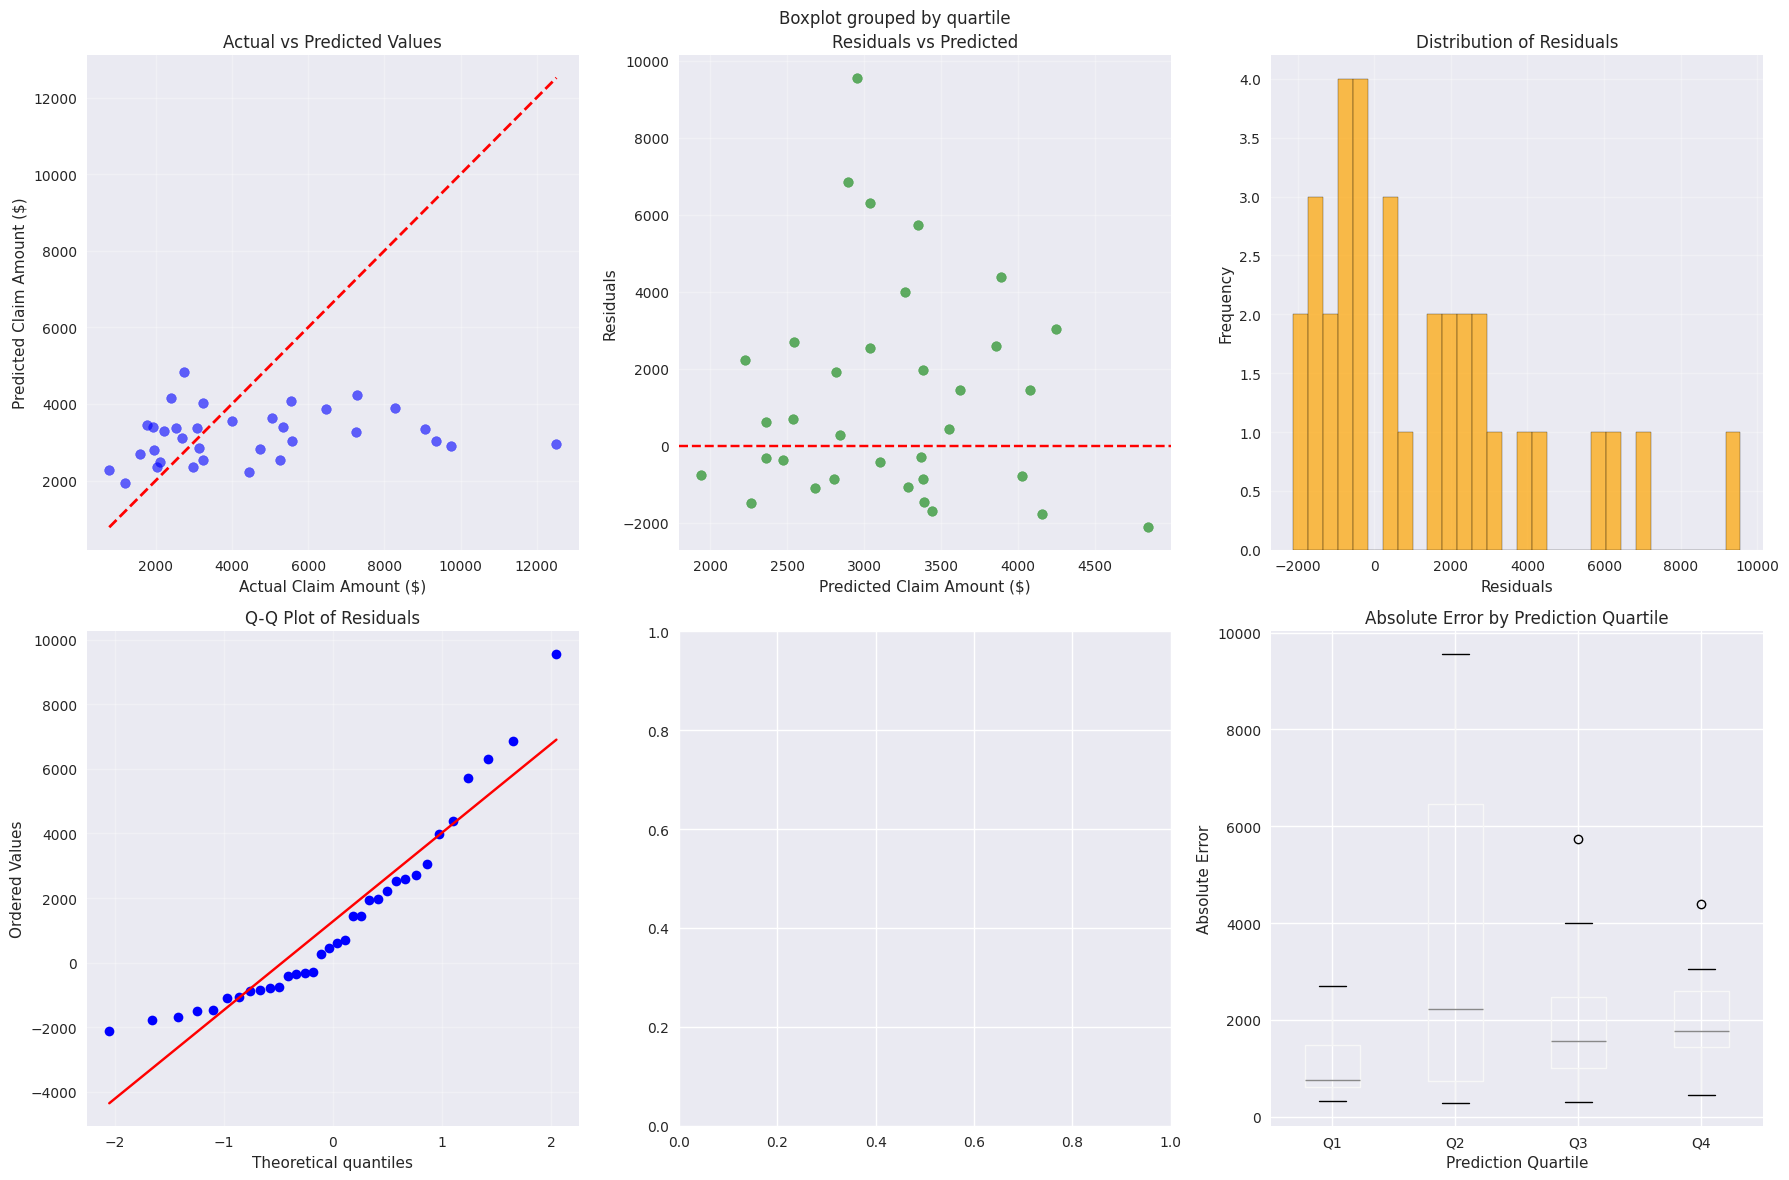

In [25]:
# Create comprehensive visualization plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Use original scale for visualizations if log-transformed
if use_log_target:
    y_test_plot = y_test_orig
    y_pred_plot = y_pred_orig
    scale_label = 'Claim Amount ($)'
else:
    y_test_plot = y_test
    y_pred_plot = y_pred
    scale_label = 'Claim Amount ($)'

# 1. Actual vs Predicted
axes[0,0].scatter(y_test_plot, y_pred_plot, alpha=0.6, color='blue')
min_val = min(y_test_plot.min(), y_pred_plot.min())
max_val = max(y_test_plot.max(), y_pred_plot.max())
axes[0,0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0,0].set_xlabel(f'Actual {scale_label}')
axes[0,0].set_ylabel(f'Predicted {scale_label}')
axes[0,0].set_title('Actual vs Predicted Values')
axes[0,0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted
residuals = y_test_plot - y_pred_plot
axes[0,1].scatter(y_pred_plot, residuals, alpha=0.6, color='green')
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel(f'Predicted {scale_label}')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residuals vs Predicted')
axes[0,1].grid(True, alpha=0.3)

# 3. Residuals distribution
axes[0,2].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0,2].set_xlabel('Residuals')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Distribution of Residuals')
axes[0,2].grid(True, alpha=0.3)

# 4. Q-Q plot for residuals normality
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot of Residuals')
axes[1,0].grid(True, alpha=0.3)

# 5. Prediction intervals
# sorted_indices = np.argsort(y_pred_plot)
# y_pred_sorted = y_pred_plot[sorted_indices]
# y_test_sorted = y_test_plot[sorted_indices]

# axes[1,1].plot(y_pred_sorted, y_test_sorted, 'bo', alpha=0.6, markersize=3)
# axes[1,1].plot(y_pred_sorted, y_pred_sorted, 'r-', lw=2, label='Perfect Prediction')
# axes[1,1].set_xlabel(f'Predicted {scale_label}')
# axes[1,1].set_ylabel(f'Actual {scale_label}')
# axes[1,1].set_title('Sorted Predictions')
# axes[1,1].legend()
# axes[1,1].grid(True, alpha=0.3)

# 6. Error distribution by prediction magnitude
# Bin predictions into quartiles
pred_quartiles = pd.qcut(y_pred_plot, q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
error_by_quartile = pd.DataFrame({
    'quartile': pred_quartiles,
    'absolute_error': np.abs(residuals)
})

error_by_quartile.boxplot(column='absolute_error', by='quartile', ax=axes[1,2])
axes[1,2].set_title('Absolute Error by Prediction Quartile')
axes[1,2].set_xlabel('Prediction Quartile')
axes[1,2].set_ylabel('Absolute Error')

plt.tight_layout()
plt.savefig('regression_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Feature Importance Analysis

TOP 15 MOST IMPORTANT FEATURES FOR CLAIM SEVERITY
 1. total_harsh_events_mean             0.0964
 2. harsh_braking_events_mean           0.0585
 3. composite_risk_score                0.0562
 4. harsh_driving_intensity             0.0549
 5. distance_miles_std                  0.0324
 6. duration_minutes_std                0.0322
 7. short_trip_flag_mean                0.0286
 8. total_driving_time_minutes          0.0261
 9. speeding_percent_mean               0.0257
10. phone_usage_flag_mean               0.0255
11. sharp_cornering_events_sum          0.0254
12. avg_duration_per_trip               0.0232
13. speed_risk_score                    0.0230
14. phone_usage_seconds_sum             0.0224
15. total_trips                         0.0223


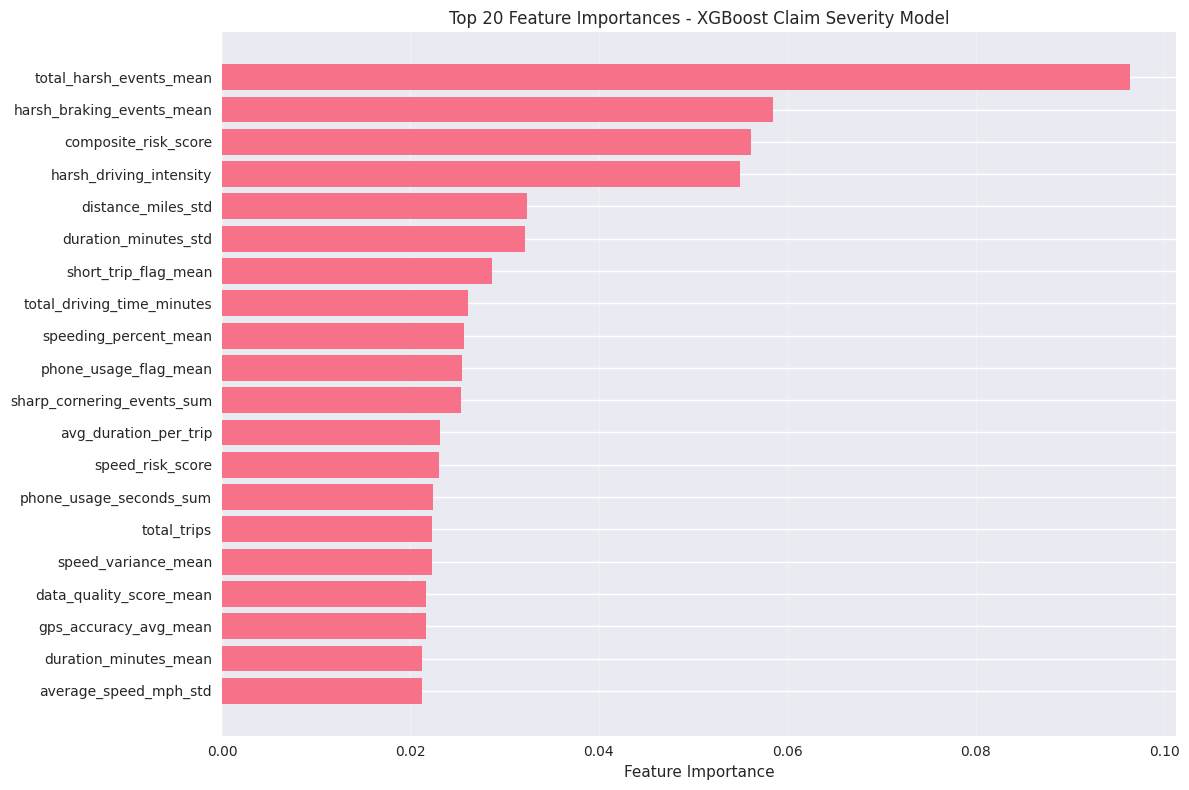


✓ Feature importance saved to: severity_feature_importance.csv


In [21]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top features
print("TOP 15 MOST IMPORTANT FEATURES FOR CLAIM SEVERITY")
print("=" * 60)
for i, (_, row) in enumerate(feature_importance.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<35} {row['importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances - XGBoost Claim Severity Model')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('severity_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save feature importance
feature_importance.to_csv('severity_feature_importance.csv', index=False)
print(f"\n✓ Feature importance saved to: severity_feature_importance.csv")

## 10. Business Insights and Severity Analysis

In [22]:
# Create severity segments based on predicted amounts
if use_log_target:
    pred_amounts = y_pred_orig
    actual_amounts = y_test_orig
else:
    pred_amounts = y_pred
    actual_amounts = y_test

test_results = pd.DataFrame({
    'driver_id': df_claims.loc[X_test.index, 'driver_id'],
    'actual_severity': actual_amounts,
    'predicted_severity': pred_amounts,
    'prediction_error': actual_amounts - pred_amounts,
    'absolute_error': np.abs(actual_amounts - pred_amounts),
    'percentage_error': np.abs(actual_amounts - pred_amounts) / actual_amounts * 100
})

# Define severity segments
test_results['severity_segment'] = pd.cut(
    test_results['predicted_severity'],
    bins=[0, 2000, 5000, 10000, np.inf],
    labels=['Low Severity', 'Medium Severity', 'High Severity', 'Very High Severity']
)

# Analyze segments
segment_analysis = test_results.groupby('severity_segment').agg({
    'driver_id': 'count',
    'actual_severity': ['mean', 'median', 'std'],
    'predicted_severity': ['mean', 'median', 'std'],
    'absolute_error': ['mean', 'median'],
    'percentage_error': ['mean', 'median']
}).round(2)

segment_analysis.columns = ['Count', 'Actual_Mean', 'Actual_Median', 'Actual_Std',
                          'Pred_Mean', 'Pred_Median', 'Pred_Std',
                          'MAE_Mean', 'MAE_Median', 'MAPE_Mean', 'MAPE_Median']

print("SEVERITY SEGMENTATION ANALYSIS")
print("=" * 60)
print(segment_analysis)

# Model accuracy by severity level
print(f"\nModel Accuracy by Severity Level:")
print("=" * 40)
for segment in segment_analysis.index:
    mape = segment_analysis.loc[segment, 'MAPE_Mean']
    mae = segment_analysis.loc[segment, 'MAE_Mean']
    print(f"{segment:<20}: MAPE={mape:.1f}%, MAE=${mae:,.0f}")

# Identify high-error predictions
high_error_threshold = test_results['percentage_error'].quantile(0.9)
high_error_cases = test_results[test_results['percentage_error'] > high_error_threshold]

print(f"\nHigh Error Cases (>{high_error_threshold:.1f}% error):")
print(f"Number of cases: {len(high_error_cases)}")
print(f"Average error: {high_error_cases['percentage_error'].mean():.1f}%")
print(f"Average actual amount: ${high_error_cases['actual_severity'].mean():,.0f}")
print(f"Average predicted amount: ${high_error_cases['predicted_severity'].mean():,.0f}")

SEVERITY SEGMENTATION ANALYSIS
                    Count  Actual_Mean  Actual_Median  Actual_Std  \
severity_segment                                                    
Low Severity            1      1190.12        1190.12         NaN   
Medium Severity        33      4554.31        3236.88     2840.92   
High Severity           0          NaN            NaN         NaN   
Very High Severity      0          NaN            NaN         NaN   

                      Pred_Mean  Pred_Median   Pred_Std  MAE_Mean  MAE_Median  \
severity_segment                                                                
Low Severity        1943.400024  1943.400024        NaN    753.29      753.29   
Medium Severity     3215.169922  3267.850098  639.97998   2223.51     1485.84   
High Severity               NaN          NaN        NaN       NaN         NaN   
Very High Severity          NaN          NaN        NaN       NaN         NaN   

                    MAPE_Mean  MAPE_Median  
severity_segment      

In [26]:
segment_analysis

,Count,Actual_Mean,Actual_Median,Actual_Std,Pred_Mean,Pred_Median,Pred_Std,MAE_Mean,MAE_Median,MAPE_Mean,MAPE_Median
severity_segment,,,,,,,,,,,
Low Severity,1,1190.12,1190.12,NaN,1943.400024,1943.400024,NaN,753.29,753.29,63.30,63.30
Medium Severity,33,4554.31,3236.88,2840.92,3215.169922,3267.850098,639.97998,2223.51,1485.84,48.51,44.09
High Severity,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Very High Severity,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 11. Model Persistence and Summary

In [23]:
# Save the trained model
model_filename = 'xgboost_severity_model.pkl'
joblib.dump(final_model, model_filename)

# Save model metadata
model_metadata = {
    'model_type': 'XGBoost Regressor',
    'target': 'claim_amount',
    'target_transformation': 'log' if use_log_target else 'none',
    'features': list(X_train.columns),
    'n_features': len(X_train.columns),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'cv_folds': cv_folds,
    'best_params': study.best_params,
    'performance': {
        'test_rmse': test_rmse_orig if use_log_target else test_rmse,
        'test_mae': test_mae_orig if use_log_target else test_mae,
        'test_r2': test_r2_orig if use_log_target else test_r2,
        'test_mape': test_mape_orig if use_log_target else None,
        'cv_rmse_mean': final_cv_rmse.mean(),
        'cv_rmse_std': final_cv_rmse.std()
    },
    'timestamp': datetime.now().isoformat()
}

# Save metadata
import json
with open('severity_model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

# Save test results
test_results.to_csv('severity_test_predictions.csv', index=False)
segment_analysis.to_csv('severity_segment_analysis.csv')

print("SEVERITY MODEL TRAINING COMPLETED SUCCESSFULLY")
print("=" * 60)
print(f"Files created:")
print(f"  1. {model_filename} - Trained XGBoost regression model")
print(f"  2. severity_model_metadata.json - Model configuration and performance")
print(f"  3. severity_feature_importance.csv - Feature importance rankings")
print(f"  4. severity_test_predictions.csv - Test set predictions")
print(f"  5. severity_segment_analysis.csv - Severity segmentation analysis")
print(f"  6. regression_model_evaluation.png - Performance visualizations")
print(f"  7. severity_feature_importance.png - Feature importance plot")
print(f"  8. claim_severity_eda.png - Exploratory data analysis plots")

print(f"\nModel Performance Summary:")
if use_log_target:
    print(f"  • RMSE: ${test_rmse_orig:,.2f}")
    print(f"  • MAE:  ${test_mae_orig:,.2f}")
    print(f"  • MAPE: {test_mape_orig:.2f}%")
    print(f"  • R²:   {test_r2_orig:.4f}")
else:
    print(f"  • RMSE: ${test_rmse:,.2f}")
    print(f"  • MAE:  ${test_mae:,.2f}")
    print(f"  • R²:   {test_r2:.4f}")

print(f"\nReady for next notebook: Combined Risk Assessment and Premium Calculation")

SEVERITY MODEL TRAINING COMPLETED SUCCESSFULLY
Files created:
  1. xgboost_severity_model.pkl - Trained XGBoost regression model
  2. severity_model_metadata.json - Model configuration and performance
  3. severity_feature_importance.csv - Feature importance rankings
  4. severity_test_predictions.csv - Test set predictions
  5. severity_segment_analysis.csv - Severity segmentation analysis
  6. regression_model_evaluation.png - Performance visualizations
  7. severity_feature_importance.png - Feature importance plot
  8. claim_severity_eda.png - Exploratory data analysis plots

Model Performance Summary:
  • RMSE: $3,040.98
  • MAE:  $2,180.27
  • MAPE: 48.95%
  • R²:   -0.1677

Ready for next notebook: Combined Risk Assessment and Premium Calculation
